# Deskripsi tugas: Car Sales Market Value

Rusty Bargain adalah perusahaan jual beli mobil bekas yang sedang mengembangkan sebuah aplikasi untuk menarik pembeli baru. Di aplikasi tersebut, Anda bisa menemukan harga pasaran sebuah mobil. Kamu memiliki akses ke data historis: spesifikasi, versi, dan harga kendaraan. Anda perlu membuat model untuk menentukan nilainya. 

Rusty Bargain tertarik pada:

- Kualitas prediksi;
- Kecepatan model dalam memprediksi;
- Waktu yang diperlukan untuk melatih model

**Instruksi Proyek**

* Simpan dan amati datanya.
* Latih model yang berbeda dengan berbagai hyperparameter (Anda harus membuat setidaknya dua model yang berbeda, tetapi lebih banyak lebih baik. Ingat, berbagai implementasi dari gradient boosting tidak dihitung sebagai model yang berbeda). Poin utama dari langkah ini adalah untuk membandingkan metode-metode gradient boosting dengan random forest, decision tree, dan regresi linear.
* Analisis kecepatan dan kualitas model.

## 1. Persiapan Data

In [1]:
# memuat semua library

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

import sklearn.linear_model
import sklearn.metrics
import sklearn.preprocessing
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows',100)

In [2]:
#import machine learning library

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder 

import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score

import sys
print (sys.version)

3.9.5 | packaged by conda-forge | (default, Jun 19 2021, 00:32:32) 
[GCC 9.3.0]


### 1.1 Memuat Data

**Deskripsi Data**

Dataset yang Anda butuhkan tersimpan di file `/datasets/car_data.csv`. Unduh dataset.

**Fitur**
* `DateCrawled` — tanggal ketika profil diunduh dari database
* `VehicleType` — jenis bodi kendaraan
* `RegistrationYear` — tahun registrasi kendaraan
* `Gearbox` — jenis transmisi
* `Power` — daya (hp)
* `Model` — model kendaraan
* `Mileage` — jarak tempuh (diukur dalam satuan km berdasarkan dataset regional tertentu)
* `RegistrationMonth` — bulan registrasi kendaraan
* `FuelType` — jenis bahan bakar
* `Brand` — merek kendaraan
* `NotRepaired` — apakah kendaraan pernah direparasi sebelumnya
* `DateCreated` — tanggal pembuatan profil
* `NumberOfPictures` — jumlah gambar kendaraan
* `PostalCode` — kode pos pemilik profil (pengguna)
* `LastSeen` — tanggal aktivitas terakhir pengguna

**Target**
* `Price` — harga (dalam satuan Euro)

In [3]:
# membaca berkas dan menyimpannya ke df

df = pd.read_csv('/datasets/car_data.csv')

In [4]:
# membuat fungsi pengolahan data

def display_information(df):
    print('Head:')
    display(df.head())
    print ('-'*100)
    print('Info:')
    print()
    display(df.info())
    print ('-'*100)
    print('Describe:')
    display(df.describe())
    print ('-'*100)
    print('Columns with nulls:')
    display(get_precent_of_na_df(df,4))
    print ('-'*100)
    print('Shape:')
    print(df.shape)
    print ('-'*100)
    print('Duplicated:')
    print('Duplicate rows:',df.duplicated().sum(),', Duplicate percentage:', (df.duplicated().sum()*100) / df.shape[0],'%')
    
def get_precent_of_na_df(df,num):
    df_nulls = pd.DataFrame(df.isna().sum(),columns=['Missing Values'])
    df_nulls['Percent of Nulls'] = round(df_nulls['Missing Values'] / df.shape[0],num) *100
    return df_nulls

print_separator = '*' * 100

In [5]:
display_information(df)
print ('-'*100)

Head:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCo

None

----------------------------------------------------------------------------------------------------
Describe:


,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


----------------------------------------------------------------------------------------------------
Columns with nulls:


,Missing Values,Percent of Nulls
DateCrawled,0,0.00
Price,0,0.00
VehicleType,37490,10.58
RegistrationYear,0,0.00
Gearbox,19833,5.60
Power,0,0.00
Model,19705,5.56
Mileage,0,0.00
RegistrationMonth,0,0.00
FuelType,32895,9.28


----------------------------------------------------------------------------------------------------
Shape:
(354369, 16)
----------------------------------------------------------------------------------------------------
Duplicated:
Duplicate rows: 262 , Duplicate percentage: 0.07393423239617461 %
----------------------------------------------------------------------------------------------------


**Kesimpulan:**
- Terdapat 262 baris yang terduplikat, yaitu 0,07% dari total dataset.
- Menghapus baris yang terduplikat dan melakukan pengecekan.

### 1.2 Pra-pemrosesan data

In [6]:
# ganti nama kolom (jadikan semua huruf kecil).

df.columns = map(str.lower, df.columns)
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'mileage', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [7]:
# menghapus baris yang terduplikasi

df_new = df.drop_duplicates()
print(df_new.shape)

print('Duplicated:')
print("\033[1m" + 'We have {} duplicated rows.'.format(df_new.duplicated().sum()) + "\033[0m")

(354107, 16)
Duplicated:
We have 0 duplicated rows.


In [8]:
# mengindentifikasi missing value

listcar_data = df_new.columns
for car_data in listcar_data:
    print ('-'*100)
    display(df_new[car_data].value_counts(dropna=False))

----------------------------------------------------------------------------------------------------


05/03/2016 14:25    66
05/03/2016 14:26    57
16/03/2016 18:49    55
05/03/2016 14:49    54
20/03/2016 11:50    54
                    ..
24/03/2016 00:23     1
14/03/2016 03:22     1
14/03/2016 08:46     1
16/03/2016 06:06     1
05/04/2016 01:52     1
Name: datecrawled, Length: 15470, dtype: int64

----------------------------------------------------------------------------------------------------


0        10770
500       5667
1500      5391
1000      4647
1200      4589
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: price, Length: 3731, dtype: int64

----------------------------------------------------------------------------------------------------


sedan          91399
small          79753
wagon          65115
NaN            37484
bus            28752
convertible    20180
coupe          16147
suv            11991
other           3286
Name: vehicletype, dtype: int64

----------------------------------------------------------------------------------------------------


2000    24476
1999    22703
2005    22094
2001    20107
2006    19874
        ...  
4100        1
1200        1
5300        1
8888        1
2290        1
Name: registrationyear, Length: 151, dtype: int64

----------------------------------------------------------------------------------------------------


manual    268034
auto       66243
NaN        19830
Name: gearbox, dtype: int64

----------------------------------------------------------------------------------------------------


0        40218
75       24001
60       15879
150      14571
101      13286
         ...  
323          1
3454         1
1056         1
13636        1
1158         1
Name: power, Length: 712, dtype: int64

----------------------------------------------------------------------------------------------------


golf                  29215
other                 24402
3er                   19744
NaN                   19701
polo                  13057
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 251, dtype: int64

----------------------------------------------------------------------------------------------------


150000    238042
125000     36424
100000     14869
90000      11555
80000      10036
70000       8589
60000       7439
5000        6396
50000       6225
40000       4905
30000       4434
20000       3972
10000       1221
Name: mileage, dtype: int64

----------------------------------------------------------------------------------------------------


0     37347
3     34348
6     31471
4     29246
5     29131
7     27186
10    26076
12    24271
11    24167
9     23798
1     23202
8     22610
2     21254
Name: registrationmonth, dtype: int64

----------------------------------------------------------------------------------------------------


petrol      216161
gasoline     98658
NaN          32889
lpg           5307
cng            565
hybrid         233
other          204
electric        90
Name: fueltype, dtype: int64

----------------------------------------------------------------------------------------------------


volkswagen        76960
opel              39902
bmw               36881
mercedes_benz     32025
audi              29439
ford              25163
renault           17915
peugeot           10988
fiat               9634
seat               6901
mazda              5611
skoda              5490
smart              5241
citroen            5143
nissan             4936
toyota             4601
hyundai            3583
sonstige_autos     3373
volvo              3207
mini               3201
mitsubishi         3022
honda              2817
kia                2463
suzuki             2320
alfa_romeo         2311
chevrolet          1751
chrysler           1439
dacia               898
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: brand, dtype: int64

----------------------------------------------------------------------------------------------------


no     246927
NaN     71145
yes     36035
Name: notrepaired, dtype: int64

----------------------------------------------------------------------------------------------------


03/04/2016 00:00    13705
04/04/2016 00:00    13301
20/03/2016 00:00    12909
12/03/2016 00:00    12833
21/03/2016 00:00    12681
                    ...  
10/08/2015 00:00        1
17/11/2015 00:00        1
12/11/2015 00:00        1
06/12/2015 00:00        1
16/01/2016 00:00        1
Name: datecreated, Length: 109, dtype: int64

----------------------------------------------------------------------------------------------------


0    354107
Name: numberofpictures, dtype: int64

----------------------------------------------------------------------------------------------------


10115    819
65428    611
66333    343
32257    316
44145    316
        ... 
37297      1
82067      1
55626      1
91362      1
67587      1
Name: postalcode, Length: 8143, dtype: int64

----------------------------------------------------------------------------------------------------


07/04/2016 07:16    653
07/04/2016 06:45    646
06/04/2016 09:17    641
06/04/2016 04:45    640
07/04/2016 05:45    639
                   ... 
27/03/2016 14:36      1
18/03/2016 20:26      1
04/04/2016 11:35      1
21/03/2016 07:52      1
09/03/2016 09:26      1
Name: lastseen, Length: 18592, dtype: int64

In [9]:
df_new.isna().sum()

datecrawled              0
price                    0
vehicletype          37484
registrationyear         0
gearbox              19830
power                    0
model                19701
mileage                  0
registrationmonth        0
fueltype             32889
brand                    0
notrepaired          71145
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

In [10]:
# menghapus outlier berdasarkan quantil 

recordstotal = df_new.shape[0]
Q1 = df_new.quantile(0.25)
Q3 = df_new.quantile(0.75)
IQR = Q3 - Q1

print(IQR)

df_out = df_new[~((df_new < (Q1 - 3 * IQR)) | (df_new > (Q3 + 6 * IQR))).any(axis=1)]

recordsquantile = df_new.shape[0] - df_out.shape[0]
print(recordsquantile, 'record dihapus menggunakan kuantil, yaitu:', recordsquantile*100/recordstotal, '%')
print ('-'*100)
display('skew original:', df_new.skew())
print ('-'*100)
display('skew baru:', df_out.skew()) 

price                 5350.0
registrationyear         9.0
power                   74.0
mileage              25000.0
registrationmonth        6.0
numberofpictures         0.0
postalcode           40918.0
dtype: float64
22452 record dihapus menggunakan kuantil, yaitu: 6.340456415716154 %
----------------------------------------------------------------------------------------------------


'skew original:'

price                 1.430729
registrationyear     74.593789
power                60.140380
mileage              -1.724262
registrationmonth     0.081302
numberofpictures      0.000000
postalcode            0.077137
dtype: float64

----------------------------------------------------------------------------------------------------


'skew baru:'

price                1.503449
registrationyear    -0.170756
power                0.603224
mileage             -1.715706
registrationmonth    0.074250
numberofpictures     0.000000
postalcode           0.075796
dtype: float64

In [11]:
# menghilangkan kolom yang tidak diperlukan dalam prediksi

colmremove = ['datecrawled','datecreated','numberofpictures','lastseen']
df_new1 = df_out.drop(colmremove, axis=1)
print(df_new1.isna().sum())
display(df_new1.head())

price                    0
vehicletype          33600
registrationyear         0
gearbox              16528
power                    0
model                16824
mileage                  0
registrationmonth        0
fueltype             29048
brand                    0
notrepaired          65184
postalcode               0
dtype: int64


,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,postalcode
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,70435
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437


In [12]:
# memproses nilai NaN (dalam banyak kolom)

df_test = df_new1.query('vehicletype != vehicletype & power==0 & registrationmonth==0 & notrepaired != notrepaired & gearbox != gearbox')
display(df_test.head())
df_new2 = df_new1.drop(df_test.index)
recordnan = df_test.shape[0]
print(df_new2.isna().sum())

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,postalcode
94,8390,NaN,2009,NaN,0,insignia,150000,0,NaN,opel,NaN,29221
309,350,NaN,2017,NaN,0,corsa,150000,0,petrol,opel,NaN,26655
334,0,NaN,2005,NaN,0,polo,150000,0,petrol,volkswagen,NaN,35392
355,1050,NaN,2018,NaN,0,golf,150000,0,NaN,volkswagen,NaN,53567
415,0,NaN,1985,NaN,0,3er,150000,0,NaN,bmw,NaN,85051


price                    0
vehicletype          29713
registrationyear         0
gearbox              12641
power                    0
model                15585
mileage                  0
registrationmonth        0
fueltype             25883
brand                    0
notrepaired          61297
postalcode               0
dtype: int64


In [13]:
df_new2.describe()

,price,registrationyear,power,mileage,registrationmonth,postalcode
count,327768.000000,327768.000000,327768.000000,327768.000000,327768.000000,327768.000000
mean,4265.386749,2003.097252,109.291096,134950.742598,5.825474,50609.510852
std,4330.658304,6.606709,62.373921,27479.022890,3.681549,25755.750670
min,0.000000,1972.000000,0.000000,50000.000000,0.000000,1067.000000
25%,1100.000000,1999.000000,73.000000,125000.000000,3.000000,30179.000000
50%,2650.000000,2003.000000,105.000000,150000.000000,6.000000,49477.000000
75%,5999.000000,2007.000000,143.000000,150000.000000,9.000000,71131.000000
max,20000.000000,2019.000000,585.000000,150000.000000,12.000000,99998.000000


In [14]:
df_new3 = df_new2.fillna(method='ffill')
df_new4 = df_new3.fillna(method='bfill')

print(df_new4.isnull().sum())
df_new4.info()

price                0
vehicletype          0
registrationyear     0
gearbox              0
power                0
model                0
mileage              0
registrationmonth    0
fueltype             0
brand                0
notrepaired          0
postalcode           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 327768 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              327768 non-null  int64 
 1   vehicletype        327768 non-null  object
 2   registrationyear   327768 non-null  int64 
 3   gearbox            327768 non-null  object
 4   power              327768 non-null  int64 
 5   model              327768 non-null  object
 6   mileage            327768 non-null  int64 
 7   registrationmonth  327768 non-null  int64 
 8   fueltype           327768 non-null  object
 9   brand              327768 non-null  object
 10  notrepaired        

In [15]:
print('skew original:',df_new.skew())
print ('-'*100)
print('skew final:',df_new4.skew())

skew original: price                 1.430729
registrationyear     74.593789
power                60.140380
mileage              -1.724262
registrationmonth     0.081302
numberofpictures      0.000000
postalcode            0.077137
dtype: float64
----------------------------------------------------------------------------------------------------
skew final: price                1.494880
registrationyear    -0.172118
power                0.632299
mileage             -1.710939
registrationmonth    0.066796
postalcode           0.073439
dtype: float64


### 1.3 Analisis Data Eksplorasi (EDA)

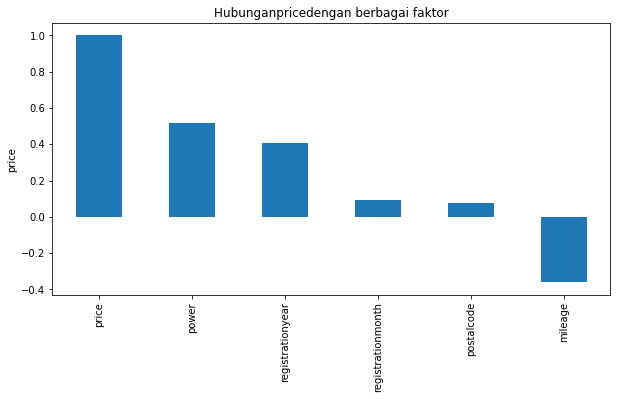

In [16]:
new_df = df_new4

plt.figure(figsize=(10,5))
ax = new_df.corr()['price'].sort_values(ascending = False).plot(kind='bar')
ax.set(title="Hubungan" +  'price'  + "dengan berbagai faktor",ylabel='price');

**Kesimpulan**
- Price memiliki korelasi positif yang kuat dengan power dan registrationyear.
- Price memiliki korelasi positif yang lemah dengan registrationmonth dan postalcode.
- Price memiliki korelasi negatif yang kuat dengan mileage.semakin banyak jarak tempuh, semakin turun costnya.

## 2. Pelatihan Model

### 2.1 Feature Engineering 

In [17]:
# menetapkan features dan target

features = new_df.drop('price', axis=1)
target = new_df['price']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [18]:
# encode categorical features

cat_list = ['vehicletype','registrationyear','gearbox','model','registrationmonth','fueltype','brand','notrepaired','postalcode']
encoder = OrdinalEncoder()

df_enc = new_df
df_enc[cat_list] = encoder.fit_transform(df_enc[cat_list])
display(df_enc.head())

features_enc = df_enc.drop('price', axis=1)
target_enc = df_enc['price']

features_train_enc, features_test_enc, target_train_enc, target_test_enc = train_test_split(
    features_enc, target_enc, test_size=0.25, random_state=12345)

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,postalcode
0,480,2.0,21.0,1.0,0,116.0,150000,0.0,6.0,38.0,1.0,4892.0
1,18300,2.0,39.0,1.0,190,116.0,125000,5.0,2.0,1.0,1.0,4609.0
2,9800,6.0,32.0,0.0,163,117.0,125000,8.0,2.0,14.0,1.0,6981.0
3,1500,5.0,29.0,1.0,75,116.0,150000,6.0,6.0,38.0,0.0,7021.0
4,3600,5.0,36.0,1.0,69,101.0,90000,7.0,2.0,31.0,0.0,4206.0


In [19]:
# membuat one hot encoding features

encoder = OneHotEncoder(categories=cat_list, sparse=False)

df_tmp = new_df.astype(int)
df_ohe = df_tmp
display(df_tmp.head(5))

features_ohe = df_ohe.drop('price', axis=1)
target_ohe = df_ohe['price']
tmp = features_ohe[cat_list]

features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(
    features_ohe, target_ohe, test_size=0.25, random_state=12345)

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,postalcode
0,480,2,21,1,0,116,150000,0,6,38,1,4892
1,18300,2,39,1,190,116,125000,5,2,1,1,4609
2,9800,6,32,0,163,117,125000,8,2,14,1,6981
3,1500,5,29,1,75,116,150000,6,6,38,0,7021
4,3600,5,36,1,69,101,90000,7,2,31,0,4206


In [20]:
# rmse

df_predictions = pd.DataFrame()
df_predictions['actual'] = target_test

def rmse_scorer(target: np.ndarray, predicted: np.ndarray):
    return np.sqrt(mean_squared_error(target, predicted))
    
rmse_scoring = make_scorer(rmse_scorer, greater_is_better=False)

**Kesimpulan:**
- Membagi data menjadi dua yaitu train set dan test set dengan perbandingan 75:25 karena data yang tersedia cukup besar.
- Mengkonversi Ordinal Encoding pada data kategorikal untuk model LightGBM dan model CatBoost.
- Membuat fitur OHE karena model seperti Linear Regression, Random Forest, Decision Tree Regressor, dan XGBoost memerlukan data kategorikal dalam bentuk OHE.

## 3. Analisis model

In [21]:
# membuat dataframe untuk dataframe name, model name and model results

column_names = ['model_name','fit-runtime (ms)','predict-runtime (ms)','rmse-runtime (ms)','rmse','hyperparameters']

df_results = pd.DataFrame(columns = column_names)
display(df_results)

,model_name,fit-runtime (ms),predict-runtime (ms),rmse-runtime (ms),rmse,hyperparameters


In [22]:
def update_results(model_name,hyperparam,resultfit,resultpredict,resultrmse,rmse_model,df_results):
    result_row_str= [model_name,resultfit,resultpredict,resultrmse,rmse_model,hyperparam]
    
    rows = [pd.Series(result_row_str, index=df_results.columns)]
  
    df_results = df_results.append(rows,ignore_index=True)
    
    display(df_results)
    return(df_results)

In [23]:
def times_of_model(model1,features_train1,target_train1,features_test1,target_test1):
    startfit = time.time()
    model1.fit(features_train1, target_train1)
    timefit = time.time() - startfit

    startpredict = time.time()
    predicted_test = model1.predict(features_test1)
    timepredict = time.time() - startpredict

    startrmse = time.time()
    rmse_model = rmse_scorer(target_test1, predicted_test) 
    timermse = time.time() - startrmse

    return(predicted_test,timefit*1000,timepredict*1000,timermse*1000,rmse_model)

### 3.1 Linear Regression

In [24]:
model = LinearRegression()  
model.fit(features_train_ohe, target_train_ohe)

target_pred_train_lr = model.predict(features_train_ohe)
target_pred_test_lr = model.predict(features_test_ohe)

print(' Root Mean Squared Error Train:', np.sqrt(mean_squared_error(target_train_ohe, target_pred_train_lr)))
print(' Root Mean Squared Error Test:', np.sqrt(mean_squared_error(target_test_ohe, target_pred_test_lr)))

 Root Mean Squared Error Train: 2917.9010836439115
 Root Mean Squared Error Test: 2913.331460080309


In [25]:
model_name = 'LinearRegression'
hyperparam = 'none'
model = LinearRegression()

predicted,timefit,timepredict,timermse,rmse_model = times_of_model(model,features_train_ohe,target_train_ohe,features_test_ohe,target_test_ohe) 
df_predictions[model_name] = predicted

df_results = update_results(model_name,hyperparam,timefit,timepredict,timermse,rmse_model,df_results)

,model_name,fit-runtime (ms),predict-runtime (ms),rmse-runtime (ms),rmse,hyperparameters
0,LinearRegression,208.382368,5.274057,0.82159,2913.33146,none


### 3.2 Random Forest Regressor

In [26]:
rf_result = defaultdict(list)

for n in range(1,11):
    model = RandomForestRegressor(random_state=42, max_depth=n, n_estimators=10)
    model.fit(features_train_ohe.to_numpy(), target_train_ohe.to_numpy())
    
    target_pred_train_rf = model.predict(features_train_ohe.to_numpy())
    target_pred_test_rf = model.predict(features_test_ohe.to_numpy())
    
    rf_result['max_depth'].append(n)
    rf_result['train_rmse'].append(np.sqrt(mean_squared_error(target_train_ohe.to_numpy(), target_pred_train_rf)))
    rf_result['test_rmse'].append(np.sqrt(mean_squared_error(target_test_ohe.to_numpy(), target_pred_test_rf)))
    
display(pd.DataFrame(rf_result))

,max_depth,train_rmse,test_rmse
0,1,3645.279742,3633.978022
1,2,3097.912487,3093.952650
2,3,2849.793838,2834.512953
3,4,2577.997357,2566.363263
4,5,2408.836310,2393.086353
5,6,2258.424621,2241.869106
6,7,2142.236873,2135.030952
7,8,2050.483782,2054.664888
8,9,1954.836690,1980.820147
9,10,1857.566261,1915.186547


In [27]:
model_name = "RandomForestRegressor"
hyperparam = 'Max_Depth = 10'

predicted,timefit,timepredict,timermse,rmse_model = times_of_model(model,features_train_ohe,target_train_ohe,features_test_ohe,target_test_ohe) 
df_predictions[model_name] = predicted

df_results = update_results(model_name,hyperparam,timefit,timepredict,timermse,rmse_model,df_results)

,model_name,fit-runtime (ms),predict-runtime (ms),rmse-runtime (ms),rmse,hyperparameters
0,LinearRegression,208.382368,5.274057,0.821590,2913.331460,none
1,RandomForestRegressor,7120.327711,114.483356,0.968695,1915.186547,Max_Depth = 10


### 3.3 Decision Tree Regressor

In [28]:
dtr_result = defaultdict(list)

for depth in range(1,10):
    model = DecisionTreeRegressor(max_depth=depth, random_state=12345)
    model.fit(features_train_ohe, target_train_ohe)
    
    target_pred_train_dtr = model.predict(features_train_ohe)
    target_pred_test_dtr = model.predict(features_test_ohe)
    
    dtr_result['max_depth'].append(depth)
    dtr_result['train_rmse'].append(np.sqrt(mean_squared_error(target_train_ohe, target_pred_train_dtr)))
    dtr_result['test_rmse'].append(np.sqrt(mean_squared_error(target_test_ohe, target_pred_test_dtr)))
    
display(pd.DataFrame(dtr_result))

,max_depth,train_rmse,test_rmse
0,1,3645.276304,3633.951897
1,2,3121.958631,3119.317819
2,3,2876.641469,2862.194757
3,4,2608.612837,2595.288708
4,5,2447.130810,2433.263549
5,6,2294.158943,2274.765901
6,7,2184.242940,2176.191328
7,8,2100.340745,2105.273458
8,9,2013.957758,2052.243639


In [29]:
model_name = "DecisionTreeRegressor"
hyperparam = 'Max_Depth = 9'

predicted,timefit,timepredict,timermse,rmse_model = times_of_model(model,features_train_ohe,target_train_ohe,features_test_ohe,target_test_ohe) 
df_predictions[model_name] = predicted

df_results = update_results(model_name,hyperparam,timefit,timepredict,timermse,rmse_model,df_results)

,model_name,fit-runtime (ms),predict-runtime (ms),rmse-runtime (ms),rmse,hyperparameters
0,LinearRegression,208.382368,5.274057,0.821590,2913.331460,none
1,RandomForestRegressor,7120.327711,114.483356,0.968695,1915.186547,Max_Depth = 10
2,DecisionTreeRegressor,1057.388544,10.220528,0.600100,2052.243639,Max_Depth = 9


### 3.4 XGBoost Regressor

In [30]:
xgb_result = defaultdict(list)

for n in range(1,6):
    model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=n)
    model.fit(features_train_ohe.to_numpy(), target_train_ohe.to_numpy())
    
    target_pred_train_xg = model.predict(features_train_ohe.to_numpy())
    target_pred_test_xg = model.predict(features_test_ohe.to_numpy())
    
    xgb_result['max_depth'].append(n)
    xgb_result['train_rmse'].append(np.sqrt(mean_squared_error(target_train_ohe.to_numpy(), target_pred_train_xg)))
    xgb_result['test_rmse'].append(np.sqrt(mean_squared_error(target_test_ohe.to_numpy(), target_pred_test_xg)))
    
display(pd.DataFrame(xgb_result))

,max_depth,train_rmse,test_rmse
0,1,2275.608547,2256.786191
1,2,1944.900173,1925.803862
2,3,1823.202771,1810.177842
3,4,1741.257022,1754.389267
4,5,1662.993488,1710.701663


In [31]:
model_name = "XGBoostRegressor"
hyperparam = 'Max_Depth = 5'

predicted,timefit,timepredict,timermse,rmse_model = times_of_model(model,features_train_ohe,target_train_ohe,features_test_ohe,target_test_ohe) 
df_predictions[model_name] = predicted

df_results = update_results(model_name,hyperparam,timefit,timepredict,timermse,rmse_model,df_results)

,model_name,fit-runtime (ms),predict-runtime (ms),rmse-runtime (ms),rmse,hyperparameters
0,LinearRegression,208.382368,5.274057,0.821590,2913.331460,none
1,RandomForestRegressor,7120.327711,114.483356,0.968695,1915.186547,Max_Depth = 10
2,DecisionTreeRegressor,1057.388544,10.220528,0.600100,2052.243639,Max_Depth = 9
3,XGBoostRegressor,36025.190592,357.609510,0.753641,1710.701663,Max_Depth = 5


### 3.5 LightGBM Regressor

In [32]:
lgb_result = defaultdict(list)

for n in [10, 20, 30, 50, 70, 100]:
    model = LGBMRegressor(objective='rmse', num_leaves=n, max_depth=5)
    model.fit(features_train_enc, target_train_enc)
    
    target_pred_train_lgb = model.predict(features_train_enc)
    target_pred_test_lgb = model.predict(features_test_enc)
    
    lgb_result['depth'].append(n)
    lgb_result['train_rmse'].append(np.sqrt(mean_squared_error(target_train_enc, target_pred_train_lgb)))
    lgb_result['test_rmse'].append(np.sqrt(mean_squared_error(target_test_enc, target_pred_test_lgb)))
    
display(pd.DataFrame(lgb_result))

,depth,train_rmse,test_rmse
0,10,1870.262140,1853.629781
1,20,1807.245141,1802.002334
2,30,1780.802294,1783.968921
3,50,1779.389750,1783.436158
4,70,1779.389750,1783.436158
5,100,1779.389750,1783.436158


In [33]:
model_name = "LGBMRegressor"
hyperparam = 'depth = 100'

predicted,timefit,timepredict,timermse,rmse_model = times_of_model(model,features_train_enc,target_train_enc,features_test_enc,target_test_enc) 
df_predictions[model_name] = predicted

df_results = update_results(model_name,hyperparam,timefit,timepredict,timermse,rmse_model,df_results)

,model_name,fit-runtime (ms),predict-runtime (ms),rmse-runtime (ms),rmse,hyperparameters
0,LinearRegression,208.382368,5.274057,0.821590,2913.331460,none
1,RandomForestRegressor,7120.327711,114.483356,0.968695,1915.186547,Max_Depth = 10
2,DecisionTreeRegressor,1057.388544,10.220528,0.600100,2052.243639,Max_Depth = 9
3,XGBoostRegressor,36025.190592,357.609510,0.753641,1710.701663,Max_Depth = 5
4,LGBMRegressor,5665.428400,717.234850,0.822783,1783.436158,depth = 100


### 3.6 CatBoost Regressor

In [34]:
cbr_result = defaultdict(list)

for n in range(1, 11):
    model = CatBoostRegressor(loss_function='RMSE', depth=n, iterations=150, random_seed=42)
    model.fit(features_train_enc, target_train_enc, verbose=False)
    
    target_pred_train_cbr = model.predict(features_train_enc)
    target_pred_test_cbr = model.predict(features_test_enc)
    
    cbr_result['depth'].append(n)
    cbr_result['train_rmse'].append(np.sqrt(mean_squared_error(target_train_enc, target_pred_train_cbr)))
    cbr_result['test_rmse'].append(np.sqrt(mean_squared_error(target_test_enc, target_pred_test_cbr)))
    
display(pd.DataFrame(cbr_result))

,depth,train_rmse,test_rmse
0,1,2211.322391,2190.132788
1,2,1898.864244,1879.168020
2,3,1807.263460,1795.635708
3,4,1747.570957,1745.123218
4,5,1700.590241,1717.454765
5,6,1657.875533,1696.005213
6,7,1616.014213,1676.022269
7,8,1571.761516,1673.547812
8,9,1512.972267,1656.694916
9,10,1452.922589,1654.274434


In [35]:
model_name = "CatBoostRegressor"
hyperparam = 'depth = 10'

predicted,timefit,timepredict,timermse,rmse_model = times_of_model(model,features_train_enc,target_train_enc,features_test_enc,target_test_enc)
df_predictions[model_name] = predicted

df_results = update_results(model_name,hyperparam,timefit,timepredict,timermse,rmse_model,df_results)

Learning rate set to 0.456811
0:	learn: 3081.6976000	total: 155ms	remaining: 23s
1:	learn: 2472.7731300	total: 310ms	remaining: 22.9s
2:	learn: 2218.1320720	total: 470ms	remaining: 23.1s
3:	learn: 2090.9266053	total: 621ms	remaining: 22.7s
4:	learn: 1998.7765234	total: 770ms	remaining: 22.3s
5:	learn: 1947.5929336	total: 928ms	remaining: 22.3s
6:	learn: 1908.2712420	total: 1.1s	remaining: 22.5s
7:	learn: 1881.1328693	total: 1.26s	remaining: 22.3s
8:	learn: 1865.7326106	total: 1.41s	remaining: 22.2s
9:	learn: 1850.3457171	total: 1.56s	remaining: 21.8s
10:	learn: 1833.6666485	total: 1.71s	remaining: 21.6s
11:	learn: 1825.6233366	total: 1.86s	remaining: 21.4s
12:	learn: 1805.8856928	total: 2.02s	remaining: 21.3s
13:	learn: 1796.4620488	total: 2.18s	remaining: 21.2s
14:	learn: 1785.4475808	total: 2.34s	remaining: 21s
15:	learn: 1775.3246994	total: 2.49s	remaining: 20.9s
16:	learn: 1770.2861709	total: 2.65s	remaining: 20.7s
17:	learn: 1760.8948579	total: 2.8s	remaining: 20.5s
18:	learn: 175

,model_name,fit-runtime (ms),predict-runtime (ms),rmse-runtime (ms),rmse,hyperparameters
0,LinearRegression,208.382368,5.274057,0.821590,2913.331460,none
1,RandomForestRegressor,7120.327711,114.483356,0.968695,1915.186547,Max_Depth = 10
2,DecisionTreeRegressor,1057.388544,10.220528,0.600100,2052.243639,Max_Depth = 9
3,XGBoostRegressor,36025.190592,357.609510,0.753641,1710.701663,Max_Depth = 5
4,LGBMRegressor,5665.428400,717.234850,0.822783,1783.436158,depth = 100
5,CatBoostRegressor,23637.760162,72.010517,1.020670,1654.274434,depth = 10


In [36]:
display(df_predictions.describe())
print ('-'*100)
display(df_results)
print ('-'*100)

,actual,LinearRegression,RandomForestRegressor,DecisionTreeRegressor,XGBoostRegressor,LGBMRegressor,CatBoostRegressor
count,81942.000000,81942.000000,81942.000000,81942.000000,81942.000000,81942.000000,81942.000000
mean,4249.435393,4252.000457,4256.873631,4256.178166,4249.877930,4249.918416,4250.089394
std,4321.121863,3193.089468,3827.357580,3835.024384,3960.478027,3880.415081,4004.248232
min,0.000000,-5800.014626,425.737612,0.000000,-1038.639771,-445.900424,-2256.539595
25%,1100.000000,1812.996725,1393.578018,1570.416684,1325.534607,1360.637272,1293.730250
50%,2600.000000,4029.709142,2793.405314,2768.640930,2788.818604,2786.431226,2759.721976
75%,5999.000000,6423.188506,5806.105914,5566.801440,5895.905762,5922.157583,5925.347427
max,20000.000000,24098.582094,18125.501654,19500.000000,22885.974609,20773.127278,21610.001439


----------------------------------------------------------------------------------------------------


,model_name,fit-runtime (ms),predict-runtime (ms),rmse-runtime (ms),rmse,hyperparameters
0,LinearRegression,208.382368,5.274057,0.821590,2913.331460,none
1,RandomForestRegressor,7120.327711,114.483356,0.968695,1915.186547,Max_Depth = 10
2,DecisionTreeRegressor,1057.388544,10.220528,0.600100,2052.243639,Max_Depth = 9
3,XGBoostRegressor,36025.190592,357.609510,0.753641,1710.701663,Max_Depth = 5
4,LGBMRegressor,5665.428400,717.234850,0.822783,1783.436158,depth = 100
5,CatBoostRegressor,23637.760162,72.010517,1.020670,1654.274434,depth = 10


----------------------------------------------------------------------------------------------------


## Kesimpulan Akhir

Berdasarkan hasil di atas:

**Model terbaik disemua Model**
- Model terbaik untuk RMSE terendah: CatBoostRegressor
- Model terbaik untuk waktu terendah dalam training data: LinearRegression
- Model terbaik untuk waktu terendah dalam memprediksi nilai: LinearRegression

**Model terbaik diantara Catboost, LightGBM, XGBoost**
- Model terbaik untuk RMSE terendah: 
    1. CatBoostRegressor
    2. XGBoostRegressor
    3. LGBMRegressor
- Model terbaik untuk waktu terendah dalam training data:
    1. LGBMRegressor
    2. CatBoostRegressor
    3. XGBoostRegressor
- Model terbaik untuk waktu terendah dalam memprediksi nilai:
    1. CatBoostRegressor
    2. XGBoostRegressor
    3. LGBMRegressor
    
**Model terburuk disemua Model**
- Model terburuk untuk RMSE: LinearRegression
- Model terburuk - waktu tertinggi dalam training data: XGBoostRegressor
- Model terburuk - waktu tertinggi dalam memprediksi nilai: LGBMRegressor

In [37]:
print("Thank you for evaluating my project, Looking forward to your feedback")

Thank you for evaluating my project, Looking forward to your feedback


# Daftar Periksa

Ketik 'x' untuk memeriksa. Lalu, tekan tombol Shift+Enter

- [x]  Jupyter Notebook dibuka
- [ ]  Tidak ada kesalahan pada kode
- [ ]  Sel-sel dengan kode telah tersusun dalam urutan yang sesuai untuk dieksekusi
- [ ]  Data telah diunduh dan disiapkan
- [ ]  Model sudah dilatih
- [ ]  Kecepatan dan kualitas analisis model telah dilakukan